In [1]:
# %%
# ============================================================================
# UNIFORM COMPRESSION ANALYSIS
# Plotting accuracy vs compression ratio and energy retention levels
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import copy
import time
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# %%
def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# %%
# Set random seeds for reproducibility
set_all_seeds(42)

print("PyTorch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

PyTorch version: 2.5.1
Device: cuda


In [2]:
# %%
def algorithm_11_randomized_svd_power_iteration(A, k, q=2):
    """
    Algorithm 11: Randomized SVD with Power Iteration
    Performs a randomized singular value decomposition on matrix A.

    Args:
        A (np.ndarray): The input matrix to decompose.
        k (int): The target rank for the approximation.
        q (int): Number of power iterations (default is 2).

    Returns:
        tuple: U, Sigma, Vt components of the SVD, truncated to rank k.
    """
    m, n = A.shape

    # Step 1: Generate a random Gaussian test matrix Omega
    # The size is n x (k + p) where p is an oversampling parameter (here, k)
    # So, 2 * k columns are used for better approximation
    Omega = np.random.randn(n, 2 * k)

    # Step 2: Compute Y = A * Omega
    Y = A @ Omega

    # Step 3: Perform power iterations to improve the range approximation
    # This step enhances the decay of singular values, making the approximation more accurate
    for _ in range(q):
        Y = A @ (A.T @ Y)

    # Step 4: Compute the QR decomposition of Y
    # Q forms an orthonormal basis for the range of Y
    Q, R = np.linalg.qr(Y)

    # Step 5: Project A onto the orthonormal basis Q to get B
    # B is a smaller matrix (2k x n) that captures the essential information of A
    B = Q.T @ A

    # Step 6: Compute the SVD of the smaller matrix B
    # U_tilde, Sigma, Vt are the SVD components of B
    U_tilde, Sigma, Vt = np.linalg.svd(B, full_matrices=False)

    # Step 7: Compute the final U matrix for A
    # U is obtained by multiplying Q with U_tilde
    U = Q @ U_tilde

    # Step 8: Truncate the SVD components to the desired rank k
    # Ensure the rank does not exceed the available singular values
    rank = min(k, len(Sigma))
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]

    return U, Sigma, Vt

In [3]:
# %%
def conv_to_matrix(weight, input_shape, stride=1, padding=0):
    """
    Converts a convolutional layer's weight tensor to its equivalent 2D matrix form
    (also known as Toeplitz matrix or Im2Col matrix for convolution).
    This is necessary for applying SVD, which operates on 2D matrices.

    Args:
        weight (torch.Tensor): The weight tensor of the convolutional layer
                                (out_channels, in_channels, kh, kw).
        input_shape (tuple): A dummy input shape (batch_size, channels, height, width)
                             to correctly interpret the convolutional operation.
        stride (int): Stride of the convolution.
        padding (int): Padding of the convolution.

    Returns:
        np.ndarray: The reshaped weight matrix in NumPy format.
    """
    # out_channels: number of output feature maps
    # in_channels: number of input feature maps
    # kh, kw: kernel height and width
    out_channels, in_channels, kh, kw = weight.shape

    # Reshape the weight tensor into a 2D matrix:
    # (out_channels) x (in_channels * kh * kw)
    # Each row corresponds to a single output filter.
    # Each column corresponds to a flattened kernel element across all input channels.
    weight_matrix = weight.view(out_channels, -1)

    # Convert to NumPy array for SVD computation
    return weight_matrix.cpu().numpy()

def linear_to_matrix(weight):
    """
    Converts a linear layer's weight tensor to its 2D matrix form.
    For a linear layer, the weight is already in a 2D matrix form (out_features x in_features).

    Args:
        weight (torch.Tensor): The weight tensor of the linear layer
                               (out_features, in_features).

    Returns:
        np.ndarray: The weight matrix in NumPy format.
    """
    # Convert to NumPy array for SVD computation
    return weight.cpu().numpy()

In [4]:
# %%
class CompressedConv2D(nn.Module):
    """
    Compressed 2D Convolutional layer using low-rank decomposition (SVD).
    This class replaces a standard Conv2d layer with two sequential convolutional layers
    that approximate the original layer's operation using a lower rank.
    """
    def __init__(self, U, S, Vt, original_shape, stride=1, padding=0, bias=None):
        super(CompressedConv2D, self).__init__()

        # original_shape: (out_channels, in_channels, kh, kw)
        out_channels, in_channels, kh, kw = original_shape
        rank = len(S) # The rank determined by SVD

        self.original_shape = original_shape
        self.stride = stride
        self.padding = padding
        self.rank = rank

        # The low-rank approximation is achieved by two sequential conv layers:
        # 1. conv1: Projects the input channels to 'rank' dimensions.
        #    It takes 'in_channels' and produces 'rank' feature maps.
        #    The kernel size is the original kernel size (kh, kw).
        #    Bias is set to False as the original bias is applied in conv2.
        self.conv1 = nn.Conv2d(in_channels, rank, kernel_size=(kh, kw),
                              stride=1, padding=padding, bias=False)

        # 2. conv2: Projects from 'rank' dimensions to 'out_channels'.
        #    It takes 'rank' feature maps and produces 'out_channels'.
        #    A 1x1 kernel is used for this recombination.
        #    The original stride is applied here.
        self.conv2 = nn.Conv2d(rank, out_channels, kernel_size=1,
                              stride=stride, padding=0, bias=bias is not None)

        # Initialize the weights of these two new layers using the SVD components
        self._initialize_from_svd(U, S, Vt)

        # If the original layer had a bias, apply it to the second convolutional layer
        if bias is not None:
            self.conv2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """
        Initializes the weights of conv1 and conv2 using the SVD components (U, S, Vt).
        """
        rank = len(S)
        out_channels, in_channels, kh, kw = self.original_shape

        # The Vt matrix (rank x (in_channels * kh * kw)) is reshaped and assigned to conv1's weight.
        # PyTorch Conv2d weights are (out_channels, in_channels, kh, kw).
        # For conv1, out_channels is 'rank', in_channels is 'in_channels'.
        V_reshaped = Vt.reshape(rank, in_channels, kh, kw)
        self.conv1.weight.data = torch.from_numpy(V_reshaped).float()

        # The U matrix (out_channels x rank) and singular values S (rank,) are combined
        # (U @ diag(S)) and assigned to conv2's weight.
        # PyTorch Conv2d weights for a 1x1 kernel are (out_channels, in_channels, 1, 1).
        # For conv2, out_channels is 'out_channels', in_channels is 'rank'.
        US = U @ np.diag(S)
        self.conv2.weight.data = torch.from_numpy(US).float().unsqueeze(-1).unsqueeze(-1)

    def forward(self, x):
        """
        Defines the forward pass for the compressed convolutional layer.
        """
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# %%
class CompressedLinear(nn.Module):
    """
    Compressed Linear layer using low-rank decomposition (SVD).
    This class replaces a standard Linear layer with two sequential linear layers
    that approximate the original layer's operation using a lower rank.
    """
    def __init__(self, U, S, Vt, original_shape, bias=None):
        super(CompressedLinear, self).__init__()

        # original_shape: (out_features, in_features)
        out_features, in_features = original_shape
        rank = len(S) # The rank determined by SVD

        self.original_shape = original_shape
        self.rank = rank

        # The low-rank approximation is achieved by two sequential linear layers:
        # 1. linear1: Projects the input features to 'rank' dimensions.
        #    It takes 'in_features' and produces 'rank' features.
        #    Bias is set to False as the original bias is applied in linear2.
        self.linear1 = nn.Linear(in_features, rank, bias=False)

        # 2. linear2: Projects from 'rank' dimensions to 'out_features'.
        #    It takes 'rank' features and produces 'out_features'.
        self.linear2 = nn.Linear(rank, out_features, bias=bias is not None)

        # Initialize the weights of these two new layers using the SVD components
        self._initialize_from_svd(U, S, Vt)

        # If the original layer had a bias, apply it to the second linear layer
        if bias is not None:
            self.linear2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """
        Initializes the weights of linear1 and linear2 using the SVD components (U, S, Vt).
        """
        # The Vt matrix (rank x in_features) is assigned to linear1's weight.
        # PyTorch Linear weights are (out_features, in_features).
        # For linear1, out_features is 'rank', in_features is 'in_features'.
        self.linear1.weight.data = torch.from_numpy(Vt).float()

        # The U matrix (out_features x rank) and singular values S (rank,) are combined
        # (U @ diag(S)) and assigned to linear2's weight.
        # PyTorch Linear weights are (out_features, in_features).
        # For linear2, out_features is 'out_features', in_features is 'rank'.
        US = U @ np.diag(S)
        self.linear2.weight.data = torch.from_numpy(US).float()

    def forward(self, x):
        """
        Defines the forward pass for the compressed linear layer.
        """
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [5]:
# %%
class LayerAnalysisCNN(nn.Module):
    """
    CNN architecture for layer-wise compression analysis.
    This model is designed with multiple convolutional and fully connected layers
    to allow for individual layer compression.
    """
    def __init__(self, num_classes=10):
        super(LayerAnalysisCNN, self).__init__()

        # Convolutional layers
        # Each conv layer is followed by ReLU activation implicitly in forward pass
        # and then Max Pooling.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # Input: 3 channels (RGB), Output: 64 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input: 64 channels, Output: 128 channels
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # Input: 128 channels, Output: 256 channels
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # Input: 256 channels, Output: 512 channels

        # Max Pooling layer with 2x2 kernel and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # The input size to fc1 depends on the output size of conv4 after pooling.
        # Assuming 32x32 input images (e.g., CIFAR-10):
        # conv1 output size: 32x32 (padding=1 keeps size)
        # pool1 output size: 16x16 (32/2)
        # conv2 output size: 16x16
        # pool2 output size: 8x8 (16/2)
        # conv3 output size: 8x8
        # pool3 output size: 4x4 (8/2)
        # conv4 output size: 4x4
        # pool4 output size: 2x2 (4/2)
        # The number of channels after conv4 is 512.
        # So, the flattened input to fc1 will be 512 * 2 * 2 = 2048.
        self.fc1 = nn.Linear(512 * 2 * 2, 1024) # Input: 2048 features, Output: 1024 features
        self.fc2 = nn.Linear(1024, 512) # Input: 1024 features, Output: 512 features
        self.fc3 = nn.Linear(512, num_classes) # Input: 512 features, Output: num_classes (e.g., 10 for CIFAR-10)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Store layer information in an OrderedDict for easy iteration and analysis.
        # This allows accessing layers by name and categorizing them by type and position.
        self.layer_info = OrderedDict([
            ('conv1', {'layer': self.conv1, 'type': 'conv', 'position': 'early'}),
            ('conv2', {'layer': self.conv2, 'type': 'conv', 'position': 'early'}),
            ('conv3', {'layer': self.conv3, 'type': 'conv', 'position': 'middle'}),
            ('conv4', {'layer': self.conv4, 'type': 'conv', 'position': 'middle'}),
            ('fc1', {'layer': self.fc1, 'type': 'fc', 'position': 'late'}),
            ('fc2', {'layer': self.fc2, 'type': 'fc', 'position': 'late'}),
            ('fc3', {'layer': self.fc3, 'type': 'fc', 'position': 'final'})
        ])

    def forward(self, x):
        """
        Defines the forward pass of the CNN model.
        """
        # Apply convolutional layers, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the output tensor for the fully connected layers.
        # x.size(0) is the batch size.
        x = x.view(x.size(0), -1)

        # Apply fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout after the first FC layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # Apply dropout after the second FC layer
        x = self.fc3(x) # Final output layer (no activation here, CrossEntropyLoss expects logits)

        return x

In [6]:
# %%
def load_cifar10_only(batch_size=128):
    """
    Loads and preprocesses the CIFAR-10 dataset.

    Args:
        batch_size (int): The batch size for the DataLoaders.

    Returns:
        dict: A dictionary containing DataLoaders for CIFAR-10 training and testing.
    """
    # Define transformations for the training dataset:
    # RandomCrop for data augmentation, RandomHorizontalFlip for more augmentation,
    # ToTensor to convert images to PyTorch tensors,
    # Normalize to standardize pixel values using CIFAR-10 mean and std.
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Randomly crop image with padding
        transforms.RandomHorizontalFlip(), # Randomly flip image horizontally
        transforms.ToTensor(), # Convert PIL Image or NumPy array to PyTorch Tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize with CIFAR-10 mean and std
    ])

    # Define transformations for the test dataset:
    # Only ToTensor and Normalize are applied, as augmentation is not needed for testing.
    transform_test = transforms.Compose([
        transforms.ToTensor(), # Convert PIL Image or NumPy array to PyTorch Tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize with CIFAR-10 mean and std
    ])

    # Load CIFAR-10 training and test datasets.
    # root='./data' specifies where to download/find the dataset.
    # download=True ensures the dataset is downloaded if not already present.
    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Create DataLoaders for efficient batching and shuffling.
    # num_workers=2 enables multi-process data loading for faster training.
    datasets = {
        'CIFAR-10': (
            DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2),
            DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)
        )
    }

    return datasets

# %%
def train_model(model, trainloader, testloader, epochs=15, lr=0.001):
    """
    Trains a given PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        trainloader (DataLoader): DataLoader for the training dataset.
        testloader (DataLoader): DataLoader for the test dataset (used for evaluation during training).
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        tuple: The trained model and its best test accuracy achieved during training.
    """
    model.to(device) # Move the model to the specified device (GPU if available, else CPU)
    criterion = nn.CrossEntropyLoss() # Define the loss function (Cross-Entropy for classification)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Define the optimizer (Adam)

    best_acc = 0 # Initialize best accuracy to track the highest performance
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device) # Move data to device

            optimizer.zero_grad() # Clear previous gradients
            outputs = model(inputs) # Perform forward pass
            loss = criterion(outputs, targets) # Calculate the loss
            loss.backward() # Perform backward pass (compute gradients)
            optimizer.step() # Update model parameters

        # Evaluate the model on the test set after each epoch
        test_acc = evaluate_model(model, testloader)
        best_acc = max(best_acc, test_acc) # Update best accuracy if current is higher

        # Print progress periodically
        if epoch % 3 == 0: # Print accuracy every 3 epochs
            print(f"Epoch {epoch:2d}: Test Acc={test_acc:.2f}%")

    return model, best_acc

# %%
def evaluate_model(model, dataloader):
    """
    Evaluates the accuracy of a given PyTorch model on a dataset.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        dataloader (DataLoader): DataLoader for the dataset to evaluate on.

    Returns:
        float: The accuracy of the model in percentage.
    """
    model.eval() # Set the model to evaluation mode (disables dropout, batch normalization updates, etc.)
    correct, total = 0, 0 # Initialize counters for correct predictions and total samples

    with torch.no_grad(): # Disable gradient computation for evaluation (saves memory and speeds up)
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device) # Move data to device
            outputs = model(inputs) # Perform forward pass
            _, predicted = outputs.max(1) # Get the index of the max log-probability (the predicted class)
            correct += predicted.eq(targets).sum().item() # Count correct predictions
            total += targets.size(0) # Accumulate total samples

    return 100. * correct / total # Calculate and return accuracy as a percentage

# %%
def fine_tune_compressed_model(model, trainloader, testloader, epochs=3, lr=0.0001):
    """
    Fine-tunes a compressed model for a few epochs to recover accuracy.

    Args:
        model (nn.Module): The compressed PyTorch model to be fine-tuned.
        trainloader (DataLoader): DataLoader for the training dataset.
        testloader (DataLoader): DataLoader for the test dataset (for final evaluation).
        epochs (int): Number of fine-tuning epochs.
        lr (float): Learning rate for fine-tuning.

    Returns:
        float: The final test accuracy after fine-tuning.
    """
    model.train() # Set the model to training mode
    criterion = nn.CrossEntropyLoss() # Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

    for epoch in range(epochs):
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            # Limit batches to speed up fine-tuning for analysis purposes.
            # This makes the fine-tuning process faster for exploration,
            # but a real fine-tuning might use more data.
            # REMOVED/COMMENTED OUT:
            # if batch_idx > 15:
            #     break
            inputs, targets = inputs.to(device), targets.to(device) # Move data to device

            optimizer.zero_grad() # Clear gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, targets) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update parameters

    return evaluate_model(model, testloader) # Return final accuracy after fine-tuning

# %%
def calculate_total_parameters(model):
    """
    Calculates the total number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: Total number of parameters.
    """
    # Sum the number of elements (numel) for all parameters in the model.
    # This includes weights and biases for all layers.
    return sum(p.numel() for p in model.parameters())

In [7]:
# %%
def compress_all_layers_by_ratio(model, target_ratio):
    """
    Compresses all eligible layers (Conv2d and Linear) in the model using SVD.
    For each layer, the rank is chosen such that its individual compression ratio
    (original_params / compressed_params) is as close as possible to the `target_ratio`.

    Args:
        model (nn.Module): The PyTorch model to be compressed.
        target_ratio (float): The desired compression ratio (e.g., 2.0 for 2x compression).

    Returns:
        tuple:
            - float: The actual overall compression ratio of the entire model after compression.
            - dict: A dictionary containing the actual compression ratio for each compressed layer.
    """
    # Determine the device the model is on to ensure new layers are moved to the same device.
    device = next(model.parameters()).device

    layer_ratios = {} # To store individual layer compression ratios

    # Calculate the total parameters of the original model before any modifications.
    # This is used to compute the overall compression ratio at the end.
    original_model_params_count = calculate_total_parameters(model)

    # Iterate through each layer defined in the model's layer_info.
    for layer_name, info in model.layer_info.items():
        layer = info['layer'] # Get the actual layer module
        weight = layer.weight.data # Get the weight tensor of the layer
        original_shape = weight.shape # Store the original shape of the weight tensor

        # Determine the matrix form (W_matrix) for SVD and the maximum possible rank.
        # Also define a lambda function to estimate compressed parameters for a given rank.
        if isinstance(layer, nn.Conv2d):
            # For Conv2d, the weight matrix is (out_channels x (in_channels * kh * kw)).
            W_matrix = conv_to_matrix(weight, (1, original_shape[1], 32, 32)) # Dummy input_shape
            # The maximum rank for SVD of a matrix is min(rows, columns).
            # For Conv2d, this is min(out_channels, in_channels * kh * kw).
            max_rank = min(original_shape[0], original_shape[1] * original_shape[2] * original_shape[3])

            # Lambda to calculate estimated compressed parameters for a Conv2d layer at a given rank 'r'.
            # This is based on the parameter count of the two sequential CompressedConv2D layers.
            # Parameters = (rank * in_channels * kh * kw) + (out_channels * rank)
            calc_comp_params = lambda r: r * original_shape[1] * original_shape[2] * original_shape[3] + original_shape[0] * r

        elif isinstance(layer, nn.Linear):
            # For Linear, the weight matrix is (out_features x in_features).
            W_matrix = linear_to_matrix(weight)
            # The maximum rank for SVD of a matrix is min(rows, columns).
            # For Linear, this is min(out_features, in_features).
            max_rank = min(original_shape[0], original_shape[1])

            # Lambda to calculate estimated compressed parameters for a Linear layer at a given rank 'r'.
            # Parameters = (rank * in_features) + (out_features * rank)
            calc_comp_params = lambda r: r * original_shape[1] + original_shape[0] * r

        else:
            # If the layer is not a Conv2d or Linear layer (e.g., BatchNorm, Dropout), skip it.
            continue

        original_layer_params = weight.numel() # Get the original number of parameters for this layer

        # Find the best rank (k) for this layer.
        # The goal is to find 'k' such that original_layer_params / calc_comp_params(k) is closest to target_ratio.
        best_rank = max_rank # Start by assuming full rank is the best (or a safe starting point)
        min_ratio_diff = float('inf') # Initialize minimum difference to infinity

        # Iterate through all possible ranks from 1 up to the maximum rank for this layer.
        for r in range(1, max_rank + 1):
            compressed_params_at_r = calc_comp_params(r)

            # Avoid division by zero if estimated compressed parameters are zero (shouldn't happen for r >= 1).
            if compressed_params_at_r == 0:
                continue

            current_layer_ratio = original_layer_params / compressed_params_at_r

            # Calculate the absolute difference between the current layer's ratio and the target ratio.
            diff = abs(current_layer_ratio - target_ratio)

            # If this rank yields a smaller difference, it's a better candidate for `best_rank`.
            if diff < min_ratio_diff:
                min_ratio_diff = diff
                best_rank = r

        # Ensure the chosen rank is at least 1, as rank 0 is not meaningful for SVD.
        rank_to_use = max(1, best_rank)

        # Perform Randomized SVD on the layer's weight matrix using the determined rank.
        U, S, Vt = algorithm_11_randomized_svd_power_iteration(W_matrix, rank_to_use, q=2)

        # Get the bias tensor from the original layer, if it exists.
        bias = layer.bias.data if layer.bias is not None else None

        # Create a new compressed layer instance (either CompressedConv2D or CompressedLinear).
        if isinstance(layer, nn.Conv2d):
            # For Conv2d, pass original_shape, stride, padding, and bias.
            compressed_layer = CompressedConv2D(U, S, Vt, original_shape, layer.stride[0], layer.padding[0], bias)
        elif isinstance(layer, nn.Linear):
            # For Linear, pass original_shape and bias.
            compressed_layer = CompressedLinear(U, S, Vt, original_shape, bias)

        # Move the newly created compressed layer to the same device as the original model.
        compressed_layer = compressed_layer.to(device)

        # Replace the original layer in the model with the new compressed layer.
        # This modifies the model in place for subsequent calculations and evaluation.
        setattr(model, layer_name, compressed_layer)

        # Calculate the actual number of parameters in the *newly created compressed layer*.
        # This is more accurate than `calc_comp_params` as it accounts for biases and exact layer structure.
        compressed_layer_params_actual = calculate_total_parameters(compressed_layer)

        # Store the actual compression ratio achieved for this specific layer.
        layer_ratios[layer_name] = original_layer_params / compressed_layer_params_actual

    # After all eligible layers have been compressed, calculate the overall actual compression ratio
    # for the entire model (total original params / total new params).
    actual_total_compressed_params = calculate_total_parameters(model)
    overall_actual_ratio = original_model_params_count / actual_total_compressed_params

    # Return the overall actual compression ratio and the dictionary of individual layer ratios.
    return overall_actual_ratio, layer_ratios

In [8]:
# %%
def compress_all_layers_by_energy(model, energy_retention):
    """
    Compresses all eligible layers (Conv2d and Linear) in the model using SVD.
    For each layer, the rank is chosen such that the retained energy (sum of squared singular values)
    is at least the `energy_retention` percentage of the total energy.

    Args:
        model (nn.Module): The PyTorch model to be compressed.
        energy_retention (float): The target percentage of energy to retain (e.g., 0.99 for 99%).

    Returns:
        dict: A dictionary containing the actual compression ratio for each compressed layer.
    """
    # Determine the device the model is on to ensure new layers are moved to the same device.
    device = next(model.parameters()).device

    compression_ratios = {} # To store individual layer compression ratios

    # Iterate through each layer defined in the model's layer_info.
    for layer_name, info in model.layer_info.items():
        layer = info['layer'] # Get the actual layer module
        weight = layer.weight.data # Get the weight tensor of the layer
        original_shape = weight.shape # Store the original shape of the weight tensor

        # Determine the matrix form (W_matrix) for SVD based on layer type.
        if isinstance(layer, nn.Conv2d):
            # For Conv2d, the weight matrix is (out_channels x (in_channels * kh * kw)).
            W_matrix = conv_to_matrix(weight, (1, weight.shape[1], 32, 32)) # Dummy input_shape
            # Stride and padding are needed for creating CompressedConv2D later.
            stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
            padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding
        elif isinstance(layer, nn.Linear):
            # For Linear, the weight matrix is (out_features x in_features).
            W_matrix = linear_to_matrix(weight)
            # Stride and padding are not applicable for Linear layers.
            stride, padding = None, None
        else:
            # If the layer is not a Conv2d or Linear layer, skip it.
            continue

        # Compute the full SVD of the layer's weight matrix.
        # full_matrices=False ensures that U and Vt are not unnecessarily large.
        U_full, S_full, Vt_full = np.linalg.svd(W_matrix, full_matrices=False)

        # Calculate the cumulative sum of squared singular values (energy).
        # Normalize by the total energy to get cumulative energy retention percentages.
        energy_cumsum = np.cumsum(S_full**2) / np.sum(S_full**2)

        # Find the smallest rank 'k' that retains at least the `energy_retention` level.
        # np.argmax returns the index of the first occurrence of the maximum value.
        # We add 1 because ranks are 1-indexed (index 0 corresponds to rank 1).
        rank = np.argmax(energy_cumsum >= energy_retention) + 1

        # Ensure the determined rank does not exceed the maximum possible rank (min(rows, cols) of W_matrix).
        # Also, ensure the rank is at least 1 (a rank of 0 is not valid for SVD).
        rank = min(rank, len(S_full)) # len(S_full) is the maximum possible rank
        rank = max(rank, 1) # Rank must be at least 1

        # Apply Randomized SVD with the determined rank.
        U, S, Vt = algorithm_11_randomized_svd_power_iteration(W_matrix, rank, q=2)

        # Get the bias tensor from the original layer, if it exists.
        bias = layer.bias.data if layer.bias is not None else None

        # Create a new compressed layer instance (either CompressedConv2D or CompressedLinear).
        if isinstance(layer, nn.Conv2d):
            # For Conv2d, pass original_shape, stride, padding, and bias.
            compressed_layer = CompressedConv2D(U, S, Vt, original_shape, stride, padding, bias)
        elif isinstance(layer, nn.Linear):
            # For Linear, pass original_shape and bias.
            compressed_layer = CompressedLinear(U, S, Vt, original_shape, bias)

        # Move the newly created compressed layer to the same device as the original model.
        compressed_layer = compressed_layer.to(device)

        # Replace the original layer in the model with the new compressed layer.
        # This modifies the model in place for subsequent calculations and evaluation.
        setattr(model, layer_name, compressed_layer)

        # Calculate the actual compression ratio for this specific layer.
        # original_params = number of parameters in the original layer.
        # compressed_params = number of parameters in the new compressed layer.
        original_params = weight.numel()
        compressed_params = calculate_total_parameters(compressed_layer) # Use actual parameters of new layer
        compression_ratios[layer_name] = original_params / compressed_params

    # Return the dictionary of individual layer compression ratios.
    return compression_ratios

In [ ]:
# %%
def uniform_compression_analysis(original_model, trainloader, testloader, dataset_name="CIFAR-10"):
    """
    Performs a comprehensive analysis of uniform compression (both ratio-based and energy-based)
    on a given model and dataset. It evaluates accuracy before and after fine-tuning.

    Args:
        original_model (nn.Module): The pre-trained, uncompressed model.
        trainloader (DataLoader): DataLoader for the training dataset (for fine-tuning).
        testloader (DataLoader): DataLoader for the test dataset (for evaluation).
        dataset_name (str): Name of the dataset for logging and plotting titles.

    Returns:
        tuple:
            - list: Results for ratio-based compression experiments.
            - list: Results for energy-based compression experiments.
            - float: Baseline accuracy of the original model.
    """
    print(f"="*80)
    print(f"UNIFORM COMPRESSION ANALYSIS - {dataset_name}")
    print(f"="*80)

    # Get the baseline accuracy of the original, uncompressed model.
    baseline_accuracy = evaluate_model(original_model, testloader)
    print(f"Baseline accuracy: {baseline_accuracy:.2f}%")

    # Define the target compression ratios for ratio-based compression experiments.
    compression_ratios_targets = [1.25, 1.33, 1.41, 1.49, 1.57, 1.65, 1.73, 1.81, 1.89, 1.97, 2.06, 2.14, 2.22, 2.30, 2.38, 2.46, 2.54, 2.62, 2.70, 2.78, 2.86, 2.94, 3.02, 3.10, 3.18, 3.26, 3.34, 3.42, 3.50, 3.58, 3.67, 3.75, 3.83, 3.91, 3.99, 4.07, 4.15, 4.23, 4.31, 4.39, 4.47, 4.55, 4.63, 4.71, 4.79, 4.87, 4.95, 5.03, 5.11, 5.19, 5.28, 5.36, 5.44, 5.52, 5.60, 5.68, 5.76, 5.84, 5.92, 6.00]
    # Define the target energy retention levels for energy-based compression experiments.
    energy_levels_targets = [0.99, 0.98, 0.97, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.92, 0.91, 0.90, 0.89, 0.88, 0.87, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.82, 0.81, 0.80, 0.79, 0.78, 0.77, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.72, 0.71, 0.70, 0.69, 0.68, 0.67, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.62, 0.61, 0.60, 0.59, 0.58, 0.57, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.52, 0.51, 0.50]

    # Lists to store the results of each compression experiment.
    # These will be used for plotting and generating summary tables.
    ratio_results = []
    energy_results = []

    print("\n--- Testing Compression Ratios (Uniformly applied per layer) ---")
    # Iterate through each target compression ratio for ratio-based compression.
    for target_ratio in compression_ratios_targets:
        print(f"Testing {target_ratio}x compression...")

        # Create a deep copy of the original model for each compression experiment.
        # This ensures that each experiment starts with the same trained, uncompressed model.
        num_classes = original_model.fc3.out_features # Get number of classes from the original model
        model_copy = LayerAnalysisCNN(num_classes=num_classes) # Create a new instance of the model architecture
        model_copy.load_state_dict(original_model.state_dict()) # Load the trained weights from the original model
        model_copy.to(device) # Move the model copy to the correct device

        try:
            # Calculate the total parameters of the model copy before compression.
            # This is used to compute the overall actual compression ratio.
            original_total_params = calculate_total_parameters(model_copy)

            # Apply uniform compression based on the target ratio.
            # The `compress_all_layers_by_ratio` function modifies `model_copy` in-place.
            # It returns the actual overall compression ratio and individual layer ratios (which we discard here).
            actual_overall_ratio, _ = compress_all_layers_by_ratio(model_copy, target_ratio)

            # Evaluate the model's accuracy immediately after compression (before any fine-tuning).
            acc_before = evaluate_model(model_copy, testloader)

            # Fine-tune the compressed model to recover lost accuracy.
            # Fine-tuning epochs are set to 6 for ratio-based compression.
            acc_after = fine_tune_compressed_model(model_copy, trainloader, testloader, epochs=6)

            # Store all relevant results for this compression experiment.
            ratio_results.append({
                'target_ratio': target_ratio, # The target ratio we aimed for
                'actual_ratio': actual_overall_ratio, # The actual overall ratio achieved
                'acc_before': acc_before, # Accuracy before fine-tuning
                'acc_after': acc_after, # Accuracy after fine-tuning
                'acc_drop_before': baseline_accuracy - acc_before, # Initial accuracy drop from baseline
                'acc_drop_after': baseline_accuracy - acc_after, # Final accuracy drop from baseline
                'recovery': acc_after - acc_before # Accuracy recovered during fine-tuning
            })

            # Print a summary of the current experiment's results to the console.
            print(f"  Target: {target_ratio:.1f}x, Actual Overall: {actual_overall_ratio:.2f}x")
            print(f"  Accuracy: {acc_before:.2f}% → {acc_after:.2f}% (recovery: {acc_after-acc_before:+.2f}%)\n")

        except Exception as e:
            # If an error occurs during compression or evaluation, print an error message and continue to the next experiment.
            print(f"  Failed for {target_ratio}x compression: {e}")
            continue # Continue to the next target ratio

    print("\n--- Testing Energy Retention Levels (Uniformly applied per layer) ---")
    # Iterate through each target energy retention level for energy-based compression.
    for energy_level in energy_levels_targets:
        print(f"Testing {energy_level*100:.0f}% energy retention...")

        # Create a deep copy of the original model for each energy retention experiment.
        num_classes = original_model.fc3.out_features
        model_copy = LayerAnalysisCNN(num_classes=num_classes)
        model_copy.load_state_dict(original_model.state_dict())
        model_copy.to(device)

        try:
            # Calculate the total parameters of the model copy before compression.
            original_total_params = calculate_total_parameters(model_copy)

            # Apply energy-based compression.
            # The `compress_all_layers_by_energy` function modifies `model_copy` in-place.
            # It returns individual layer ratios (which we discard here), so we calculate overall ratio manually.
            _ = compress_all_layers_by_energy(model_copy, energy_level)

            # Calculate the actual overall compression ratio after energy-based compression.
            compressed_total_params = calculate_total_parameters(model_copy)
            actual_overall_ratio = original_total_params / compressed_total_params

            # Evaluate accuracy before fine-tuning.
            acc_before = evaluate_model(model_copy, testloader)

            # Fine-tune the compressed model.
            # Fine-tuning epochs are set to 5 for energy-based compression.
            acc_after = fine_tune_compressed_model(model_copy, trainloader, testloader, epochs=5)

            # Store results for this energy level.
            energy_results.append({
                'energy_level': energy_level, # The target energy level
                'actual_ratio': actual_overall_ratio, # The actual overall compression ratio achieved
                'acc_before': acc_before,
                'acc_after': acc_after,
                'acc_drop_before': baseline_accuracy - acc_before,
                'acc_drop_after': baseline_accuracy - acc_after,
                'recovery': acc_after - acc_before
            })

            # Print a summary of the current experiment's results.
            print(f"  Energy: {energy_level*100:.0f}%, Actual Overall Compression: {actual_overall_ratio:.2f}x")
            print(f"  Accuracy: {acc_before:.2f}% → {acc_after:.2f}% (recovery: {acc_after-acc_before:+.2f}%)\n")

        except Exception as e:
            # If an error occurs, print an error message and continue.
            print(f"  Failed for {energy_level*100:.0f}% energy retention: {e}")
            continue

    # Return the collected results and the baseline accuracy.
    return ratio_results, energy_results, baseline_accuracy

In [10]:
# %%
def plot_compression_results(ratio_results, energy_results, baseline_accuracy, dataset_name):
    """
    Creates comprehensive plots to visualize the results of the uniform compression analysis.
    It generates four subplots:
    1. Accuracy vs. Overall Compression Ratio (for ratio-based compression).
    2. Recovery & Initial Drop vs. Overall Compression Ratio (for ratio-based compression).
    3. Accuracy vs. Energy Retention (for energy-based compression).
    4. Overall Compression Ratio & Recovery vs. Energy Retention (for energy-based compression).
    It also generates an additional 2-subplot figure for trade-off analysis.
    """
    plt.style.use('default') # Reset matplotlib style to default for consistent plotting

    # Create a figure with a 2x2 grid of subplots for the main analysis.
    # figsize=(15, 12) provides a good size for displaying all four plots clearly.
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    # Set a super title for the entire figure.
    fig.suptitle(f'Uniform Compression Analysis - {dataset_name}', fontsize=16, fontweight='bold')

    # --- Plot 1: Accuracy vs Overall Compression Ratio (for ratio-based compression) ---
    if ratio_results: # Only plot if there are results for ratio-based compression
        # Extract actual overall compression ratios and accuracies before/after fine-tuning.
        ratios = [r['actual_ratio'] for r in ratio_results]
        acc_before = [r['acc_before'] for r in ratio_results]
        acc_after = [r['acc_after'] for r in ratio_results]

        # Plot accuracy before fine-tuning with circle markers and a solid line.
        ax1.plot(ratios, acc_before, 'o-', label='Before Fine-tuning', linewidth=2, markersize=8)
        # Plot accuracy after fine-tuning with square markers and a solid line.
        ax1.plot(ratios, acc_after, 's-', label='After Fine-tuning', linewidth=2, markersize=8)
        # Add a horizontal dashed line to represent the baseline accuracy of the uncompressed model.
        ax1.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7, label='Baseline')

        # Set x-axis label, y-axis label, plot title, and display the legend.
        ax1.set_xlabel('Overall Compression Ratio', fontsize=12)
        ax1.set_ylabel('Accuracy (%)', fontsize=12)
        ax1.set_title('Accuracy vs Overall Compression Ratio (Ratio-based)', fontsize=14)
        ax1.legend()
        # Add a light grid for better readability.
        ax1.grid(True, alpha=0.3)
        # Set x-axis limits to start slightly before 1.0 for better visualization of compression.
        ax1.set_xlim(left=0.8)
        # Ensure y-axis starts at 0 for clear comparison of accuracy values.
        ax1.set_ylim(bottom=0)

    # --- Plot 2: Recovery & Initial Drop vs Overall Compression Ratio (for ratio-based compression) ---
    if ratio_results:
        # Extract recovery (accuracy gained during fine-tuning) and initial accuracy drop.
        recovery = [r['recovery'] for r in ratio_results]
        acc_drop_before = [r['acc_drop_before'] for r in ratio_results] # Initial drop before fine-tuning

        # Plot recovery with triangle-up markers and a solid line.
        ax2.plot(ratios, recovery, 'g^-', label='Recovery (Acc After - Acc Before)', linewidth=2, markersize=8)
        # Plot initial accuracy drop with triangle-down markers and a solid line.
        ax2.plot(ratios, acc_drop_before, 'rv-', label='Initial Accuracy Drop (Baseline - Acc Before)', linewidth=2, markersize=8)
        # Add a horizontal line at y=0 to indicate no change in accuracy.
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # Set labels, title, legend, and grid.
        ax2.set_xlabel('Overall Compression Ratio', fontsize=12)
        ax2.set_ylabel('Accuracy Change (%)', fontsize=12)
        ax2.set_title('Recovery & Initial Drop vs Overall Compression Ratio (Ratio-based)', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(left=0.8)

    # --- Plot 3: Accuracy vs Energy Retention (for energy-based compression) ---
    if energy_results:
        # Extract energy levels (converted to percentage) and accuracies before/after fine-tuning.
        energy_levels = [r['energy_level'] * 100 for r in energy_results]
        acc_before = [r['acc_before'] for r in energy_results]
        acc_after = [r['acc_after'] for r in energy_results]

        # Plot accuracy before fine-tuning.
        ax3.plot(energy_levels, acc_before, 'o-', label='Before Fine-tuning', linewidth=2, markersize=8)
        # Plot accuracy after fine-tuning.
        ax3.plot(energy_levels, acc_after, 's-', label='After Fine-tuning', linewidth=2, markersize=8)
        # Add baseline accuracy line.
        ax3.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7, label='Baseline')

        # Set labels, title, legend, and grid.
        ax3.set_xlabel('Energy Retention (%)', fontsize=12)
        ax3.set_ylabel('Accuracy (%)', fontsize=12)
        ax3.set_title('Accuracy vs Energy Retention (Energy-based)', fontsize=14)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        # Invert x-axis to show higher energy retention (less compression) on the left.
        ax3.invert_xaxis()
        ax3.set_ylim(bottom=0)

    # --- Plot 4: Overall Compression Ratio & Recovery vs Energy Retention (for energy-based compression) ---
    if energy_results:
        # Extract energy levels, overall compression ratios, and recovery values.
        energy_levels = [r['energy_level'] * 100 for r in energy_results]
        compression_ratios_energy = [r['actual_ratio'] for r in energy_results]
        recovery_energy = [r['recovery'] for r in energy_results]

        # Create a twin y-axis (`ax4_twin`) to plot recovery on a separate scale.
        ax4_twin = ax4.twinx()

        # Plot overall compression ratio on the primary y-axis (blue line with asterisks).
        line1 = ax4.plot(energy_levels, compression_ratios_energy, 'b*-',
                        label='Overall Compression Ratio', linewidth=2, markersize=10)
        # Plot recovery on the secondary y-axis (green line with circles).
        line2 = ax4_twin.plot(energy_levels, recovery_energy, 'go-',
                             label='Recovery (Acc After - Acc Before)', linewidth=2, markersize=8)

        # Set labels and title for both axes.
        ax4.set_xlabel('Energy Retention (%)', fontsize=12)
        ax4.set_ylabel('Overall Compression Ratio', fontsize=12, color='b')
        ax4_twin.set_ylabel('Recovery (%)', fontsize=12, color='g')
        ax4.set_title('Overall Compression Ratio & Recovery vs Energy Retention (Energy-based)', fontsize=14)

        # Combine the legends from both y-axes into a single legend.
        lines_all = line1 + line2
        labels_all = [l.get_label() for l in lines_all]
        ax4.legend(lines_all, labels_all, loc='upper right')

        # Add a grid and invert the x-axis.
        ax4.grid(True, alpha=0.3)
        ax4.invert_xaxis()
        # Set tick label colors to match their respective lines.
        ax4.tick_params(axis='y', labelcolor='b')
        ax4_twin.tick_params(axis='y', labelcolor='g')

    # Adjust the layout to prevent plot elements from overlapping, leaving space for the super title.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Display the first set of plots.

    # --- Additional Detailed Plot: Trade-off Analysis ---
    # This figure shows the trade-off between accuracy drop and compression ratio for both methods.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Compression Trade-off Analysis - {dataset_name}', fontsize=16, fontweight='bold')

    # Plot 1: Accuracy Drop vs Overall Compression Ratio (Both methods)
    if ratio_results and energy_results:
        # Extract data for ratio-based compression.
        ratio_comp = [r['actual_ratio'] for r in ratio_results]
        ratio_drop = [r['acc_drop_after'] for r in ratio_results] # Accuracy drop AFTER fine-tuning

        # Extract data for energy-based compression.
        energy_comp = [r['actual_ratio'] for r in energy_results]
        energy_drop = [r['acc_drop_after'] for r in energy_results] # Accuracy drop AFTER fine-tuning

        # Scatter plot for ratio-based compression.
        ax1.scatter(ratio_comp, ratio_drop, c='blue', s=100, alpha=0.7, label='Ratio-based Compression')
        # Scatter plot for energy-based compression.
        ax1.scatter(energy_comp, energy_drop, c='red', s=100, alpha=0.7, label='Energy-based Compression')

        # Set labels, title, legend, and grid.
        ax1.set_xlabel('Overall Compression Ratio', fontsize=12)
        ax1.set_ylabel('Accuracy Drop (%) (After Fine-tuning)', fontsize=12)
        ax1.set_title('Accuracy Drop vs Overall Compression Ratio', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(left=0.8)
        # Set y-axis limits to show both positive and negative drops clearly.
        ax1.set_ylim(bottom=-5, top=baseline_accuracy + 5)

        # Add linear trend lines for both sets of data if there are enough points.
        if len(ratio_comp) > 1:
            z1 = np.polyfit(ratio_comp, ratio_drop, 1) # Fit a linear polynomial
            p1 = np.poly1d(z1) # Create a polynomial function from the coefficients
            ax1.plot(ratio_comp, p1(ratio_comp), "b--", alpha=0.8, label='_nolegend_') # Plot trend line (no legend entry)

        if len(energy_comp) > 1:
            z2 = np.polyfit(energy_comp, energy_drop, 1)
            p2 = np.poly1d(z2)
            ax1.plot(energy_comp, p2(energy_comp), "r--", alpha=0.8, label='_nolegend_') # Plot trend line

    # Plot 2: Efficiency Analysis (Final Accuracy / Compression Ratio)
    if ratio_results:
        # Calculate efficiency for ratio-based compression: (Final Accuracy) / (Actual Compression Ratio).
        # Filter out cases where actual_ratio is 0 to avoid division errors.
        efficiency_ratio = [(baseline_accuracy - r['acc_drop_after']) / r['actual_ratio']
                            for r in ratio_results if r['actual_ratio'] > 0]
        # Get the corresponding compression ratios for x-axis labels.
        ratios_for_efficiency = [r['actual_ratio'] for r in ratio_results if r['actual_ratio'] > 0]

        # Create a bar plot to visualize efficiency.
        ax2.bar(range(len(ratios_for_efficiency)), efficiency_ratio, alpha=0.7, color='purple')

        # Set labels, title, and x-axis ticks.
        ax2.set_xlabel('Overall Compression Ratio (Ratio-based)', fontsize=12)
        ax2.set_ylabel('Final Accuracy / Compression Ratio (%)', fontsize=12)
        ax2.set_title('Compression Efficiency (Ratio-based)', fontsize=14)
        ax2.set_xticks(range(len(ratios_for_efficiency))) # Set tick locations
        ax2.set_xticklabels([f'{r:.1f}x' for r in ratios_for_efficiency], rotation=45, ha='right') # Set tick labels
        ax2.grid(True, alpha=0.3)

        # Add numerical labels on top of each bar for precise values.
        for i, v in enumerate(efficiency_ratio):
            ax2.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

    # Adjust the layout and display the second set of plots.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [11]:
# %%
def generate_summary_table(ratio_results, energy_results, baseline_accuracy, dataset_name):
    """
    Generates and prints summary tables for the uniform compression analysis results.
    It provides tables for both ratio-based and energy-based compression,
    including target/actual ratios, accuracies, drops, and recovery.
    """
    print(f"\n{'='*80}")
    print(f"UNIFORM COMPRESSION SUMMARY - {dataset_name}")
    print(f"{'='*80}")
    print(f"Baseline Accuracy: {baseline_accuracy:.2f}%")

    # --- Compression Ratio Results Table ---
    if ratio_results: # Only print if there are results for ratio-based compression
        print(f"\n--- COMPRESSION RATIO RESULTS (Uniformly applied per layer) ---")
        # Print table header with aligned columns.
        print(f"{'Target':>8} {'Actual':>8} {'Before':>8} {'After':>8} {'Drop':>8} {'Recovery':>10}")
        print("-" * 60) # Print a separator line for readability.

        # Iterate through each result dictionary and print formatted data rows.
        for r in ratio_results:
            print(f"{r['target_ratio']:>8.1f} {r['actual_ratio']:>8.2f} "
                  f"{r['acc_before']:>8.2f} {r['acc_after']:>8.2f} "
                  f"{r['acc_drop_after']:>8.2f} {r['recovery']:>10.2f}")

        # Identify and print key insights for ratio-based compression.
        if ratio_results:
            # Find the experiment with the best recovery.
            best_recovery = max(ratio_results, key=lambda x: x['recovery'])
            # Find the experiment with the best final accuracy.
            best_accuracy = max(ratio_results, key=lambda x: x['acc_after'])
            # Find the experiment that achieved the highest compression ratio.
            highest_compression = max(ratio_results, key=lambda x: x['actual_ratio'])

            print(f"\nBest Recovery: {best_recovery['actual_ratio']:.2f}x compression, "
                  f"{best_recovery['recovery']:+.2f}% recovery")
            print(f"Best Final Accuracy: {best_accuracy['actual_ratio']:.2f}x compression, "
                  f"{best_accuracy['acc_after']:.2f}% accuracy")
            print(f"Highest Compression: {highest_compression['actual_ratio']:.2f}x compression, "
                  f"{highest_compression['acc_after']:.2f}% accuracy")

    # --- Energy Retention Results Table ---
    if energy_results: # Only print if there are results for energy-based compression
        print(f"\n--- ENERGY RETENTION RESULTS (Uniformly applied per layer) ---")
        # Print table header.
        print(f"{'Energy':>8} {'Ratio':>8} {'Before':>8} {'After':>8} {'Drop':>8} {'Recovery':>10}")
        print("-" * 60) # Separator line.

        # Print data rows.
        for r in energy_results:
            print(f"{r['energy_level']*100:>8.0f} {r['actual_ratio']:>8.2f} "
                  f"{r['acc_before']:>8.2f} {r['acc_after']:>8.2f} "
                  f"{r['acc_drop_after']:>8.2f} {r['recovery']:>10.2f}")

        # Identify and print key insights for energy-based compression.
        if energy_results:
            # Find the energy setting that resulted in the best final accuracy.
            best_energy_setting = max(energy_results, key=lambda x: x['acc_after'])
            print(f"\nBest Energy Setting: {best_energy_setting['energy_level']*100:.0f}% energy retention, "
                  f"{best_energy_setting['actual_ratio']:.2f}x compression, {best_energy_setting['acc_after']:.2f}% accuracy")

In [12]:
# %%
def main_uniform_analysis():
    """
    Main function to orchestrate the uniform compression analysis.
    It sets up seeds, loads the dataset, trains an original model,
    performs compression analysis (both ratio-based and energy-based),
    generates plots, and prints summary tables.
    """
    set_all_seeds(42) # Set random seeds for reproducibility across the entire analysis.
    print("Starting Uniform Compression Analysis (CIFAR-10 only)...")

    # Set the global device (GPU if available, otherwise CPU).
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Load the CIFAR-10 dataset.
    datasets = load_cifar10_only(batch_size=128)

    all_results = {} # Dictionary to store results for different datasets (though only CIFAR-10 is analyzed here).

    # Loop through each dataset (currently only CIFAR-10).
    for dataset_name, (trainloader, testloader) in datasets.items():
        print(f"\n{'='*80}")
        print(f"ANALYZING {dataset_name}")
        print(f"{'='*80}")

        # Create a new instance of the CNN model for the original training.
        num_classes = 10  # CIFAR-10 has 10 classes.
        original_model = LayerAnalysisCNN(num_classes=num_classes)

        # Train the original, uncompressed model from scratch.
        epochs = 15 # Define the number of epochs for initial training.
        original_model, best_acc = train_model(original_model, trainloader, testloader, epochs=epochs)

        print(f"Original model training completed. Best accuracy: {best_acc:.2f}%")

        # Perform the uniform compression analysis using the newly trained original model.
        # This function returns results for both ratio-based and energy-based compression.
        ratio_results, energy_results, baseline_accuracy = uniform_compression_analysis(
            original_model, trainloader, testloader, dataset_name)

        # Store the collected results in the `all_results` dictionary.
        all_results[dataset_name] = {
            'ratio_results': ratio_results,
            'energy_results': energy_results,
            'baseline_accuracy': baseline_accuracy
        }

        # Generate and display plots based on the analysis results.
        plot_compression_results(ratio_results, energy_results, baseline_accuracy, dataset_name)

        # Generate and print summary tables to the console.
        generate_summary_table(ratio_results, energy_results, baseline_accuracy, dataset_name)

    # Return all collected results.
    return all_results

Starting Uniform Compression Analysis (CIFAR-10 only)...
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

ANALYZING CIFAR-10
Epoch  0: Test Acc=50.70%
Epoch  3: Test Acc=73.00%
Epoch  6: Test Acc=76.55%
Epoch  9: Test Acc=79.54%
Epoch 12: Test Acc=79.58%
Original model training completed. Best accuracy: 80.90%
UNIFORM COMPRESSION ANALYSIS - CIFAR-10
Baseline accuracy: 80.90%

--- Testing Compression Ratios (Uniformly applied per layer) ---
Testing 1.25x compression...
  Target: 1.2x, Actual Overall: 1.25x
  Accuracy: 64.60% → 83.40% (recovery: +18.80%)

Testing 1.33x compression...
  Target: 1.3x, Actual Overall: 1.33x
  Accuracy: 60.19% → 83.95% (recovery: +23.76%)

Testing 1.41x compression...
  Target: 1.4x, Actual Overall: 1.41x
  Accuracy: 60.80% → 82.90% (recovery: +22.10%)

Testing 1.49x compression...
  Target: 1.5x, Actual Overall: 1.49x
  Accuracy: 60.73% → 83.89% (recovery: +23.16%)

Testing 1.57x compression...
  Target: 1.6x, Actual

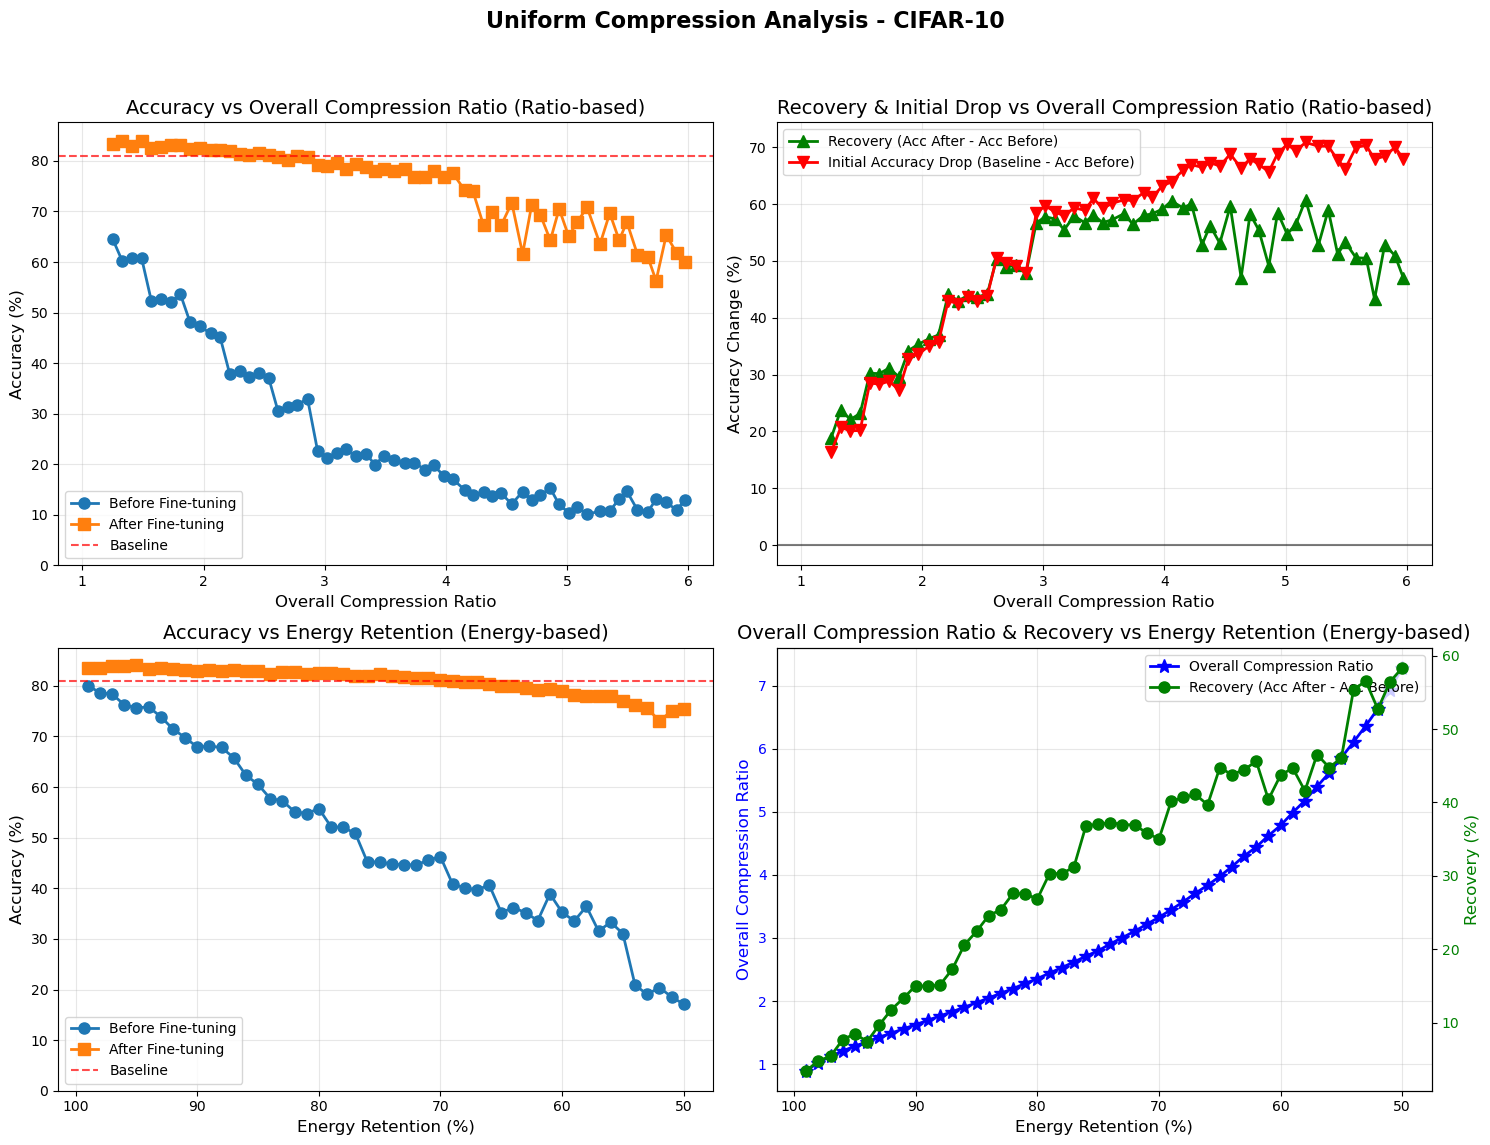

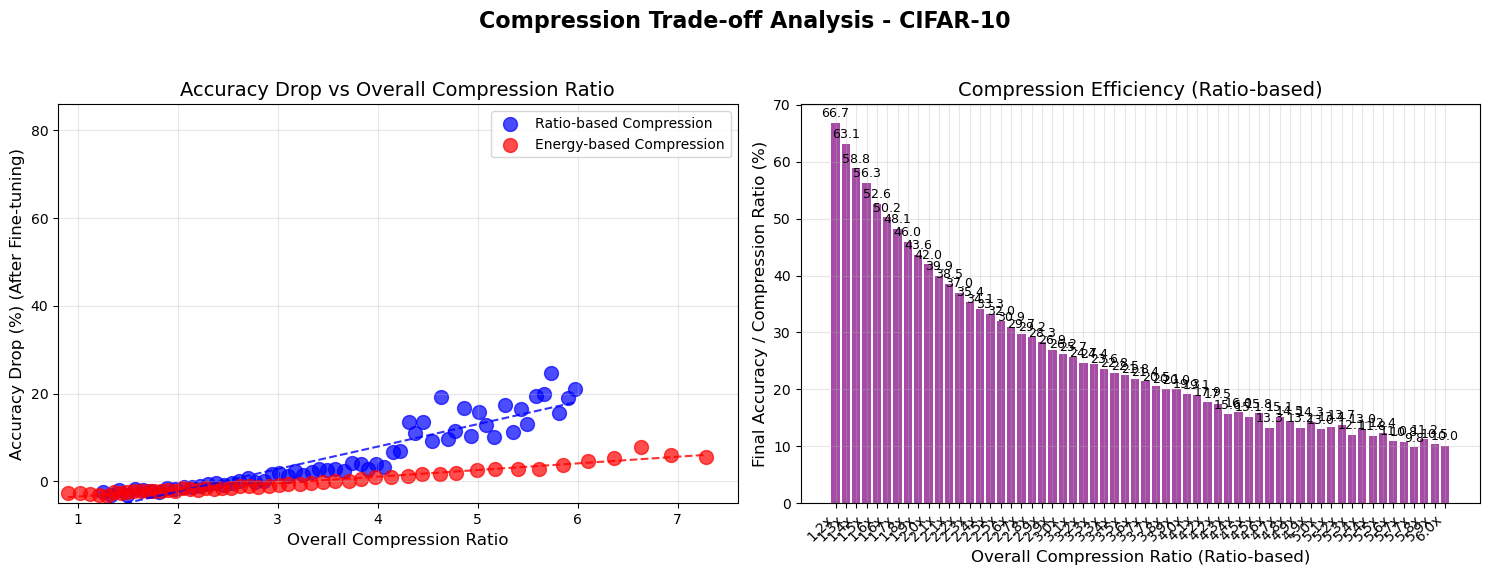


UNIFORM COMPRESSION SUMMARY - CIFAR-10
Baseline Accuracy: 80.90%

--- COMPRESSION RATIO RESULTS (Uniformly applied per layer) ---
  Target   Actual   Before    After     Drop   Recovery
------------------------------------------------------------
     1.2     1.25    64.60    83.40    -2.50      18.80
     1.3     1.33    60.19    83.95    -3.05      23.76
     1.4     1.41    60.80    82.90    -2.00      22.10
     1.5     1.49    60.73    83.89    -2.99      23.16
     1.6     1.57    52.35    82.58    -1.68      30.23
     1.6     1.65    52.61    82.78    -1.88      30.17
     1.7     1.73    52.05    83.19    -2.29      31.14
     1.8     1.81    53.62    83.21    -2.31      29.59
     1.9     1.89    48.14    82.35    -1.45      34.21
     2.0     1.97    47.25    82.56    -1.66      35.31
     2.1     2.06    45.90    82.22    -1.32      36.32
     2.1     2.14    45.19    82.16    -1.26      36.97
     2.2     2.22    37.87    82.00    -1.10      44.13
     2.3     2.30    38.

In [13]:
# %%
if __name__ == "__main__":
    # This block ensures that `main_uniform_analysis()` is called only when the script is executed directly.
    # Run the uniform compression analysis on CIFAR-10 only.
    results = main_uniform_analysis()

    # Print a final message indicating the completion of the analysis.
    print("\n" + "="*80)
    print("UNIFORM COMPRESSION ANALYSIS COMPLETED (CIFAR-10)")
    print("="*80)